# Example Predictor: SIR Predictor through parameter estimation



## Training

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import sys, os
#from os.path import pardir, sep 
sys.path.insert(1,'/'+os.path.join(*os.getcwd().split('/')[:-2]))
from utils.custom_models import SIR_parfinder
from pipeline.utils import *

### Copy the data locally

In [2]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [3]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
#urllib.request.urlretrieve(DATA_URL, DATA_FILE)

In [13]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [14]:
# For testing, restrict training data to that before a hypothetical predictor submission date
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-07-31")
df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [15]:
df=create_dataset(df)
print(df.shape)

(59214, 66)


In [7]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
# Columns we care just about the last value (usually it's always the same value for most of them)
adj_cols_fixed=[ 'ConfirmedCases','Population']#,
       #'Population Density (# per km2)',
       #'Urban population (% of total population)',
       #'Population ages 65 and above (% of total population)',
       #'GDP per capita (current US$)', 'Obesity Rate (%)', 'Cancer Rate (%)',
       #'Share of Deaths from Smoking (%)', 'Pneumonia Death Rate (per 100K)',
       #'Share of Deaths from Air Pollution (%)',
       #'CO2 emissions (metric tons per capita)',
       #'Air transport (# carrier departures worldwide)']

# Columns we would like to include for the last nb_lookback days
adj_cols_time=['TemperatureC']


cases_col = ['MA']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']


In [8]:
# Fill also missing CONFIRMED case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').ConfirmedCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [9]:
#df['PastCases']=df.ConfirmedCases.values

In [10]:
# Keep only columns of interest
df = df[id_cols+ cases_col  +adj_cols_fixed+ adj_cols_time+ npi_cols]

In [11]:
df.count()

CountryName                             59214
RegionName                              20448
GeoID                                   59214
Date                                    59214
MA                                      59214
ConfirmedCases                          59214
Population                              59214
TemperatureC                            59214
C1_School closing                       59214
C2_Workplace closing                    59214
C3_Cancel public events                 59214
C4_Restrictions on gatherings           59214
C5_Close public transport               59214
C6_Stay at home requirements            59214
C7_Restrictions on internal movement    59214
C8_International travel controls        59214
H1_Public information campaigns         59214
H2_Testing policy                       59214
H3_Contact tracing                      59214
H6_Facial Coverings                     59214
dtype: int64

In [12]:
df.loc[df.MA<0,'MA']=0

In [13]:
lookback_days=30
infection_days=7

X_samples, y_samples= skl_format(df,True,lookback_days,adj_cols_fixed,adj_cols_time)
print(X_samples.shape)
print(y_samples.shape)

(36400, 433)
(36400,)


In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_samples,
                                                    y_samples,
                                                    test_size=0.2,
                                                    random_state=301)

In [15]:
Sreg=SIR_parfinder(infection_days=infection_days,fit_days=15,nprocs=26)
Sreg.fit(X_train)

100%|██████████| 260/260 [01:38<00:00,  2.65it/s]


SIR_parfinder(nprocs=26)

# ML to predict SIR parameter

In [54]:
# Create new dataset without info on cases
X_trainML=X_train[:,lookback_days:].copy()
X_testML=X_test[:,lookback_days:].copy()
y_trainML=Sreg.labels_
y_testML=Sreg.predict(X_test)

# Precchie label sono (np.nan, np,nan) se avevamo 0 casi iniziali,
# poi dobbaimo fare in modo che il predittore dei casi sappia predire 0 nuovi casi, come fa SIR_parfinder.row_predict()
idx_notzero_train=np.where(~np.isnan(y_trainML).all(axis=1))
idx_notzero_test=np.where(~np.isnan(y_testML).all(axis=1))

X_trainML=X_trainML[idx_notzero_train].copy()
X_testML=X_testML[idx_notzero_test].copy()
y_trainML=y_trainML[idx_notzero_train].copy()
y_testML=y_testML[idx_notzero_test].copy()

print(X_trainML.shape)
print(y_trainML.shape)
print(X_testML.shape)
print(y_testML.shape)

100%|██████████| 260/260 [00:24<00:00, 10.45it/s]


(20087, 403)
(20087, 2)
(5028, 403)
(5028, 2)


In [75]:
model = Lasso(alpha=0.001,tol=0.00001,
              precompute=True,
              max_iter=100000,
              #positive=True,
              selection='random')
# Fit model
model.fit(X_trainML, y_trainML)

Lasso(alpha=0.001, max_iter=100000, precompute=True, selection='random',
      tol=1e-05)

In [76]:
# Evaluate model
train_preds = model.predict(X_trainML)
#train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
print('Train MAE:', mae(train_preds, y_trainML))

test_preds = model.predict(X_testML)
#test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
print('Test MAE:', mae(test_preds, y_testML))

Train MAE: 0.0858523420442475
Test MAE: 0.08216472301608407


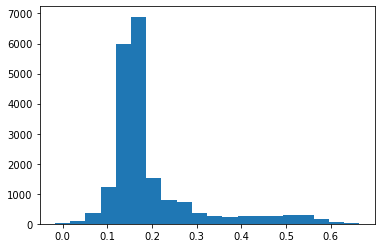

In [77]:
plt.hist(train_preds[:,0],20);

In [78]:
# Inspect the learned feature coefficients for the model
# to see what features it's paying attention to.

# Give names to the features
x_col_names = []
#for d in range(-lookback_days, 0):
#    x_col_names.append('Day ' + str(d) + ' ' + cases_col[0])
for col_name in adj_cols_fixed:
        x_col_names.append(col_name)
        
for d in range(-lookback_days, 1):
    for col_name in adj_cols_time:
        x_col_names.append('Day ' + str(d) + ' ' + col_name)
        
for d in range(-lookback_days, 1):
    for col_name in npi_cols:
        x_col_names.append('Day ' + str(d) + ' ' + col_name)

# View non-zero coefficients
print('Impact on beta')
for (col, coeff) in zip(x_col_names, list(model.coef_[0])):
    if coeff != 0.:
        print(col, coeff)
print('Intercept', model.intercept_[0])

print('\nImpact on gamma')
for (col, coeff) in zip(x_col_names, list(model.coef_[1])):
    if coeff != 0.:
        print(col, coeff)
print('Intercept', model.intercept_[1])

  0%|          | 0/20087 [14:07<?, ?it/s]

Impact on beta
PastCases -7.339261467962712e-09
Population -1.0397166727689886e-11
Population Density (# per km2) -1.4869436976293994e-06
Urban population (% of total population) 5.4087709252338384e-05
Population ages 65 and above (% of total population) -0.0028910382708602295
GDP per capita (current US$) -2.0404956463880473e-07
Obesity Rate (%) -0.0006678280958635932
Cancer Rate (%) -0.012375413150993206
Pneumonia Death Rate (per 100K) -0.00027720252061368594
Share of Deaths from Air Pollution (%) -0.0016986751819432016
CO2 emissions (metric tons per capita) 5.502216845969757e-05
Air transport (# carrier departures worldwide) 5.927478586800488e-09
Day -3 TemperatureC -0.0021554875282259363
Day 0 TemperatureC -0.009566332001039101
Day -30 C1_School closing -0.0024028502775823263
Day -30 C2_Workplace closing -0.0007980313006044103
Day -30 C6_Stay at home requirements -0.00264380495170886
Day -30 C8_International travel controls -0.005472787594798337
Day -30 H1_Public information campaig

### Convert to new cases

In [79]:
y_pred_train=np.zeros(y_train.shape)
y_pred_test=np.zeros(y_test.shape)
for i,idx in enumerate(idx_notzero_train[0]):
    y_pred_train[idx]=Sreg.row_predict(X_train[idx,:],train_preds[i])[-1] 

for i,idx in enumerate(idx_notzero_test[0]):
    y_pred_test[idx]=Sreg.row_predict(X_test[idx,:],test_preds[i])[-1] 

In [80]:
# Evaluate model on new cases
print('Train MAE:', mae(y_pred_train, y_train))
print('Test MAE:', mae(y_pred_test, y_test))

Train MAE: 298.8434335047982
Test MAE: 295.7261047321465
